In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F19447%2F31436%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T123159Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0e693518b0b53ab5aec81b65a95225da3ff38e247c69561e3c27230696d3aedd9e9573e0d3c3f13a1fcecce7270d815745f082acf6ca15d3d8a6926cf88fad39c2019a82b43752ddc60f5cbe5e8164f894c2ae9c84fb1ea9851d45900a3d8f3be679d8b23ac25f010fd1d1b4eb1a3c58105844e8b55df333e294cb5e679cae4e399d07f24360928c1277fe234ba8d72a5d4d724e548a5bbaccb2ef5f62ee90e7b2a1449becfaf761e0eaad913e647083765f3d6b05909ea05af4706d5361716eb8ce846d90df018d00079d12ee8a94cfc880043c8a787fb6f1e4944556192d4cda0f8d10e229db95f9edf59f97850abb1367a7955b2a9b25ff6593726246fb43'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 502973613 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [2]:
# keras module for building LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku
import tensorflow as tf
import numpy as np
# set seeds for reproducability

tf.random.set_seed(2)
np.random.seed(1)

import pandas as pd
import string, os

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
curr_dir = '../input/'
all_headlines = []
for filename in os.listdir(curr_dir):
    if 'Articles' in filename:
        article_df = pd.read_csv(curr_dir + filename)
        all_headlines.extend(list(article_df.headline.values))
        break

all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

1214

In [4]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt

corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression',
 'commuter reprogramming',
 'ford changed leaders looking for a lift its still looking',
 'romney failed to win at utah convention but few believe hes doomed',
 'chain reaction',
 'he forced the vatican to investigate sex abuse now hes meeting with pope francis']

In [5]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1

    ## convert data to sequence of tokens
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116]]

In [6]:
from sklearn.model_selection import train_test_split

def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    predictors, labels = input_sequences[:, :-1], input_sequences[:, -1]
    labels = ku.to_categorical(labels, num_classes=total_words)
    return predictors, labels, max_sequence_len

inp_sequences, total_words = get_sequence_of_tokens(corpus)
predictors, labels, max_sequence_len = generate_padded_sequences(inp_sequences)

predictors_train, predictors_val, labels_train, labels_val = train_test_split(predictors, labels, test_size=0.2, random_state=42)


In [7]:
import tensorflow.keras.backend as K

def kl_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

def entropy(y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return -K.sum(y_pred * K.log(y_pred), axis=-1)

In [8]:
from tensorflow import keras

class CustomMetrics(keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.kl_divergences = []
        self.entropies = []
        self.train_losses = []
        self.val_losses = []


    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        self.train_losses.append(train_loss)


        y_pred = self.model.predict(self.validation_data[0], verbose=0)
        y_true = self.validation_data[1]
        kl_div = kl_divergence(y_true, y_pred).numpy().mean()
        ent = entropy(y_pred).numpy().mean()
        self.val_losses.append(logs.get('val_loss'))

        print(f"Epoch {epoch+1}: mean KL divergence = {kl_div}, mean entropy = {ent}")
        print(f"train loss = {train_loss}")
        print(f"validation Loss = {logs.get('val_loss')}")

        self.kl_divergences.append(kl_div)
        self.entropies.append(ent)
        if logs is not None:
            logs['kl_divergence'] = kl_div
            logs['entropy'] = ent


In [9]:
def create_model(total_words, max_sequence_len, custom_loss=None):
    input_len = max_sequence_len - 1
    model = Sequential([
        Embedding(total_words, 10, input_length=input_len),
        LSTM(100),
        Dropout(0.1),
        Dense(total_words, activation='linear')
    ])
    loss = custom_loss
    model.compile(loss=loss, optimizer='adam')
    return model

def original_loss(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)

def custom_loss(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred) + 10e-8 * entropy(y_pred)


control_model = create_model(total_words, max_sequence_len, custom_loss=original_loss)
modified_model = create_model(total_words, max_sequence_len, custom_loss=custom_loss)


Lets train our model now

In [10]:

validation_data=(predictors_val, labels_val)

custom_metrics_control = CustomMetrics(validation_data)
custom_metrics_modified = CustomMetrics(validation_data)

control_model.fit(predictors_train, labels_train, epochs=5, verbose=5, validation_data=(predictors_val, labels_val), callbacks=[custom_metrics_control])


Epoch 1/5
Epoch 1: mean KL divergence = 9.408929824829102, mean entropy = 11.26097297668457
train loss = 0.00028592272428795695
validation Loss = 0.00028587208362296224
Epoch 2/5
Epoch 2: mean KL divergence = 9.368531227111816, mean entropy = 10.895499229431152
train loss = 0.0002858922234736383
validation Loss = 0.0002858638181351125
Epoch 3/5
Epoch 3: mean KL divergence = 9.344358444213867, mean entropy = 10.468036651611328
train loss = 0.0002858659718185663
validation Loss = 0.0002858566876966506
Epoch 4/5
Epoch 4: mean KL divergence = 9.411452293395996, mean entropy = 10.2631196975708
train loss = 0.0002858449297491461
validation Loss = 0.0002858361986000091
Epoch 5/5
Epoch 5: mean KL divergence = 9.45444393157959, mean entropy = 10.272432327270508
train loss = 0.00028580703656189144
validation Loss = 0.0002858156803995371


In [11]:
modified_model.fit(predictors_train, labels_train, epochs=5, verbose=5, validation_data=(predictors_val, labels_val), callbacks=[custom_metrics_modified])


Epoch 1/5
Epoch 1: mean KL divergence = 10.952901840209961, mean entropy = 6.758662223815918
train loss = 0.0002865922579076141
validation Loss = 0.0002864533453248441
Epoch 2/5
Epoch 2: mean KL divergence = 10.870038986206055, mean entropy = 6.597019195556641
train loss = 0.0002864738926291466
validation Loss = 0.00028642889810726047
Epoch 3/5
Epoch 3: mean KL divergence = 11.014057159423828, mean entropy = 6.1362690925598145
train loss = 0.00028640718664973974
validation Loss = 0.0002863579720724374
Epoch 4/5
Epoch 4: mean KL divergence = 10.93337631225586, mean entropy = 6.223325252532959
train loss = 0.00028637057403102517
validation Loss = 0.0002863676054403186
Epoch 5/5
Epoch 5: mean KL divergence = 11.245532989501953, mean entropy = 5.947267055511475
train loss = 0.00028633151669055223
validation Loss = 0.00028630689484998584


In [12]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        #predicted = model.predict_classes(token_list, verbose=0)
        predictions = model.predict(token_list, verbose=0)
        predicted = np.argmax(predictions, axis=-1)[0]

        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

Text(0.5, 1.0, 'KL Divergence over Epochs')

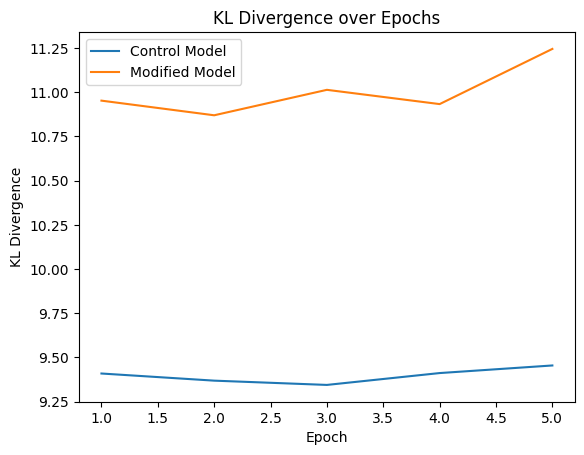

In [13]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,6), custom_metrics_control.kl_divergences, label = 'Control Model')
plt.plot(np.arange(1,6), custom_metrics_modified.kl_divergences, label = 'Modified Model')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.title('KL Divergence over Epochs')

Text(0.5, 1.0, 'Entropies over Epochs')

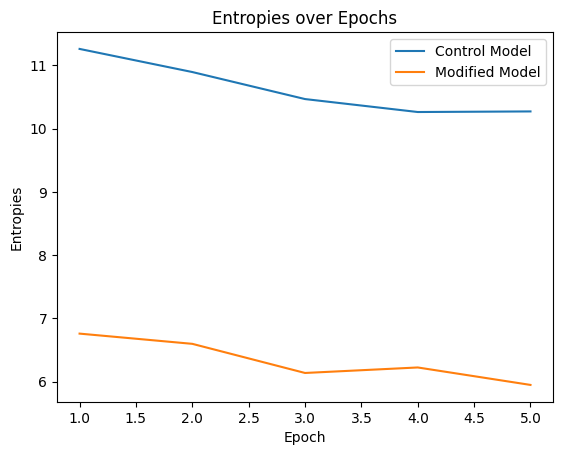

In [14]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,6), custom_metrics_control.entropies, label = 'Control Model')
plt.plot(np.arange(1,6), custom_metrics_modified.entropies, label = 'Modified Model')
plt.xlabel('Epoch')
plt.ylabel('Entropies')
plt.legend()
plt.title('Entropies over Epochs')

In [15]:
custom_metrics_control.entropies

[11.260973, 10.895499, 10.468037, 10.26312, 10.272432]

Text(0.5, 1.0, 'Entropy Difference ')

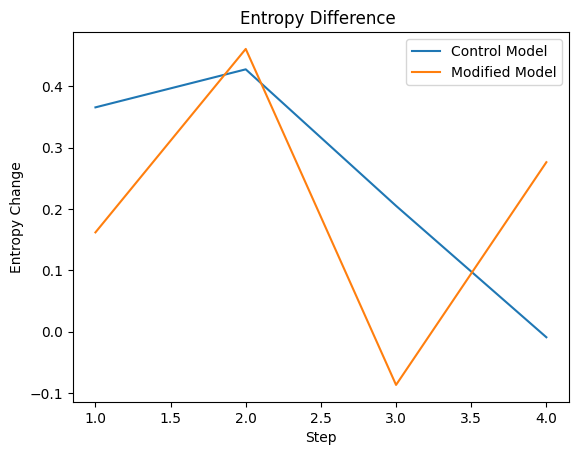

In [16]:
differences_control = []
for i in np.arange(1, len(custom_metrics_control.entropies)):
  difference = custom_metrics_control.entropies[i - 1] - custom_metrics_control.entropies[i]
  differences_control.append(difference)

differences_modified = []
for i in np.arange(1, len(custom_metrics_modified.entropies)):
  difference = custom_metrics_modified.entropies[i - 1] - custom_metrics_modified.entropies[i]
  differences_modified.append(difference)

plt.plot(np.arange(1,5), differences_control, label = 'Control Model')
plt.plot(np.arange(1,5), differences_modified, label = 'Modified Model')
plt.xlabel('Step')
plt.ylabel('Entropy Change')
plt.legend()
plt.title('Entropy Difference ')

In [17]:
rates = [1e-11, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
rate_log = [-11, -10, -9, -8, -7, -6]
average_entropies = []
average_kls = []

for i in rates:
  def create_model(total_words, max_sequence_len, custom_loss=None):
    input_len = max_sequence_len - 1
    model = Sequential([
        Embedding(total_words, 10, input_length=input_len),
        LSTM(100),
        Dropout(0.1),
        Dense(total_words, activation='linear')
    ])
    loss = custom_loss
    model.compile(loss=loss, optimizer='adam')
    return model

  def original_loss(y_true, y_pred):
      return keras.losses.mean_squared_error(y_true, y_pred)

  def custom_loss(y_true, y_pred):
      return keras.losses.mean_squared_error(y_true, y_pred) + i * entropy(y_pred)


  modified_model = create_model(total_words, max_sequence_len, custom_loss=custom_loss)
  validation_data=(predictors_val, labels_val)
  custom_metrics_modified = CustomMetrics(validation_data)
  modified_model.fit(predictors_train, labels_train, epochs=5, verbose=5, validation_data=(predictors_val, labels_val), callbacks=[custom_metrics_modified])
  print(i, custom_metrics_modified.entropies, custom_metrics_modified.kl_divergences)
  average_entropies.append(custom_metrics_modified.entropies)
  average_kls.append(custom_metrics_modified.kl_divergences)



Epoch 1/5
Epoch 1: mean KL divergence = 9.641230583190918, mean entropy = 11.305508613586426
train loss = 0.0002859233063645661
validation Loss = 0.00028589338762685657
Epoch 2/5
Epoch 2: mean KL divergence = 9.592241287231445, mean entropy = 10.871898651123047
train loss = 0.0002858927473425865
validation Loss = 0.0002858896041288972
Epoch 3/5
Epoch 3: mean KL divergence = 9.474401473999023, mean entropy = 10.469712257385254
train loss = 0.00028586050029844046
validation Loss = 0.0002858484222088009
Epoch 4/5
Epoch 4: mean KL divergence = 9.523426055908203, mean entropy = 10.484159469604492
train loss = 0.0002858306688722223
validation Loss = 0.000285852060187608
Epoch 5/5
Epoch 5: mean KL divergence = 9.553826332092285, mean entropy = 10.41033935546875
train loss = 0.00028578354977071285
validation Loss = 0.00028583305538631976
1e-11 [11.305509, 10.871899, 10.469712, 10.484159, 10.410339] [9.641231, 9.592241, 9.474401, 9.523426, 9.553826]
Epoch 1/5
Epoch 1: mean KL divergence = 9.584

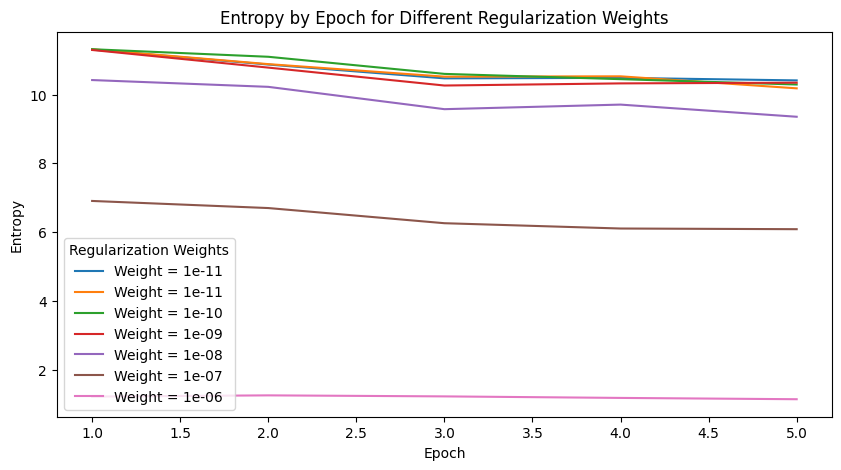

In [18]:
plt.figure(figsize=(10, 5))
for i, entropies in enumerate(average_entropies):
  plt.plot(np.arange(1,6), entropies, label = f'Weight = {rates[i]}')

plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy by Epoch for Different Regularization Weights')
plt.legend(title="Regularization Weights")
plt.show()

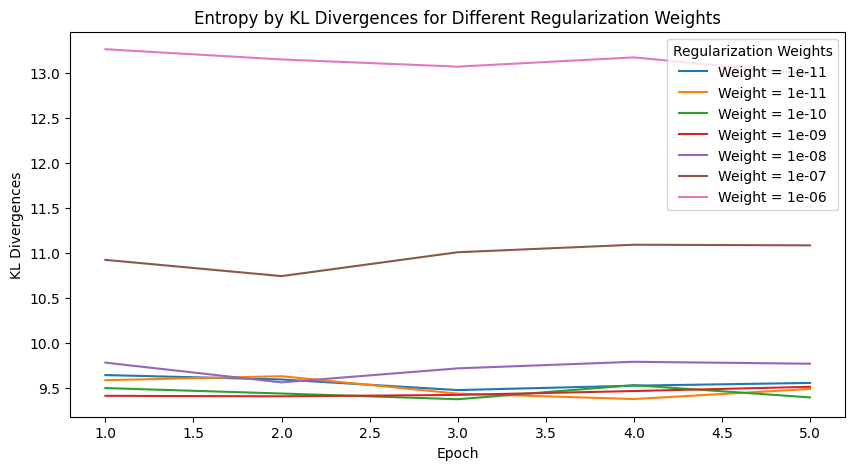

In [19]:
plt.figure(figsize=(10, 5))
for i, kls in enumerate(average_kls):
  plt.plot(np.arange(1,6), kls, label = f'Weight = {rates[i]}')

plt.xlabel('Epoch')
plt.ylabel('KL Divergences')
plt.title('Entropy by KL Divergences for Different Regularization Weights')
plt.legend(title="Regularization Weights")
plt.show()

In [20]:
average_kls

[[9.641231, 9.592241, 9.474401, 9.523426, 9.553826],
 [9.584387, 9.628472, 9.435042, 9.374892, 9.486691],
 [9.4965725, 9.436336, 9.372859, 9.529243, 9.393206],
 [9.410602, 9.40518, 9.420681, 9.46383, 9.510765],
 [9.7792015, 9.55978, 9.715597, 9.788582, 9.76722],
 [10.920624, 10.740243, 11.005402, 11.08877, 11.081911],
 [13.260172, 13.146681, 13.066543, 13.169593, 12.982088]]

In [21]:
print (generate_text("united states", 10, control_model, max_sequence_len))
print (generate_text("preident trump", 10, control_model, max_sequence_len))
print (generate_text("donald trump", 10, control_model, max_sequence_len))
print (generate_text("india and china", 10, control_model, max_sequence_len))
print (generate_text("new york", 10, control_model, max_sequence_len))
print (generate_text("science and technology", 10, control_model, max_sequence_len))

United States To A A To A A A To A A
Preident Trump A A To A A A To A A A
Donald Trump A A To A A A To A A A
India And China To A To A A A To A A A
New York To A A A To A A A To A
Science And Technology To To A A A To A A A To


In [22]:
print (generate_text("united states", 10, modified_model, max_sequence_len))
print (generate_text("preident trump", 10, modified_model, max_sequence_len))
print (generate_text("donald trump", 10, modified_model, max_sequence_len))
print (generate_text("india and china", 10, modified_model, max_sequence_len))
print (generate_text("new york", 10, modified_model, max_sequence_len))
print (generate_text("science and technology", 10, modified_model, max_sequence_len))

United States A A A A A A A A A A
Preident Trump A A A A A A A A A A
Donald Trump A A A A A A A A A A
India And China A A A A A A A A A A
New York A A A A A A A A A A
Science And Technology A A A A A A A A A A


In [23]:
def create_model(total_words, max_sequence_len, custom_loss=None):
    input_len = max_sequence_len - 1
    model = Sequential([
        Embedding(total_words, 10, input_length=input_len),
        LSTM(100),
        Dropout(0.1),
        Dense(total_words, activation='linear')
    ])
    loss = custom_loss
    model.compile(loss=loss, optimizer='adam')
    return model

def original_loss(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)

def custom_loss(y_true, y_pred):
    kl_div = kl_divergence(y_true, y_pred)
    return keras.losses.mean_squared_error(y_true, y_pred) + 10e-8 * kl_divergence(y_true, y_pred)

control_model = create_model(total_words, max_sequence_len, custom_loss=original_loss)
modified_model = create_model(total_words, max_sequence_len, custom_loss=custom_loss)


In [24]:
control_model.fit(predictors_train, labels_train, epochs=5, verbose=5, validation_data=(predictors_val, labels_val), callbacks=[custom_metrics_control])
modified_model.fit(predictors_train, labels_train, epochs=5, verbose=5, validation_data=(predictors_val, labels_val), callbacks=[custom_metrics_modified])


Epoch 1/5
Epoch 1: mean KL divergence = 9.448563575744629, mean entropy = 11.287555694580078
train loss = 0.00028594868490472436
validation Loss = 0.00028587804990820587
Epoch 2/5
Epoch 2: mean KL divergence = 9.353466033935547, mean entropy = 10.866029739379883
train loss = 0.0002858919615391642
validation Loss = 0.00028587356791831553
Epoch 3/5
Epoch 3: mean KL divergence = 9.473684310913086, mean entropy = 10.51138973236084
train loss = 0.0002858623047359288
validation Loss = 0.0002858528750948608
Epoch 4/5
Epoch 4: mean KL divergence = 9.618816375732422, mean entropy = 10.465656280517578
train loss = 0.0002858467632904649
validation Loss = 0.0002858598018065095
Epoch 5/5
Epoch 5: mean KL divergence = 9.552458763122559, mean entropy = 10.30605411529541
train loss = 0.000285802292637527
validation Loss = 0.00028582714730873704
Epoch 1/5
Epoch 1: mean KL divergence = 9.340215682983398, mean entropy = 13.245323181152344
train loss = 0.0002874559140764177
validation Loss = 0.00028751872

In [25]:
rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2]
rate_log = [-5, -4, -3, -2, -1, 0, 1, 2]
average_entropies = []
average_kls = []
training_losses = []
validation_losses = []

for i in rates:
  def create_model(total_words, max_sequence_len, custom_loss=None):
    input_len = max_sequence_len - 1
    model = Sequential([
        Embedding(total_words, 10, input_length=input_len),
        LSTM(100),
        Dropout(0.1),
        Dense(total_words, activation='linear')
    ])
    loss = custom_loss
    model.compile(loss=loss, optimizer='adam')
    return model

  def original_loss(y_true, y_pred):
      return keras.losses.mean_squared_error(y_true, y_pred)

  def custom_loss(y_true, y_pred):
      return keras.losses.mean_squared_error(y_true, y_pred) + i * kl_divergence(y_true, y_pred)


  modified_model = create_model(total_words, max_sequence_len, custom_loss=custom_loss)
  validation_data=(predictors_val, labels_val)
  custom_metrics_modified = CustomMetrics(validation_data)
  modified_model.fit(predictors_train, labels_train, epochs=5, verbose=5, validation_data=(predictors_val, labels_val), callbacks=[custom_metrics_modified])
  print(i, custom_metrics_modified.entropies, custom_metrics_modified.kl_divergences)
  average_entropies.append(custom_metrics_modified.entropies)
  average_kls.append(custom_metrics_modified.kl_divergences)
  training_losses.append(custom_metrics_modified.train_losses)
  validation_losses.append(custom_metrics_modified.val_losses)




Epoch 1/5
Epoch 1: mean KL divergence = 8.192753791809082, mean entropy = 38.46450424194336
train loss = 0.00038448176928795874
validation Loss = 0.00038829646655358374
Epoch 2/5
Epoch 2: mean KL divergence = 7.6016950607299805, mean entropy = 52.34204864501953
train loss = 0.0003834224189631641
validation Loss = 0.0003930936218239367
Epoch 3/5
Epoch 3: mean KL divergence = 7.506697654724121, mean entropy = 51.191505432128906
train loss = 0.0003893755201715976
validation Loss = 0.00039736408507451415
Epoch 4/5
Epoch 4: mean KL divergence = 7.42725133895874, mean entropy = 51.91905212402344
train loss = 0.0003848517080768943
validation Loss = 0.0003942769253626466
Epoch 5/5
Epoch 5: mean KL divergence = 7.621884346008301, mean entropy = 50.315582275390625
train loss = 0.0003781549457926303
validation Loss = 0.0003970203106291592
1e-05 [38.464504, 52.34205, 51.191505, 51.919052, 50.315582] [8.192754, 7.601695, 7.5066977, 7.4272513, 7.6218843]
Epoch 1/5
Epoch 1: mean KL divergence = 7.634

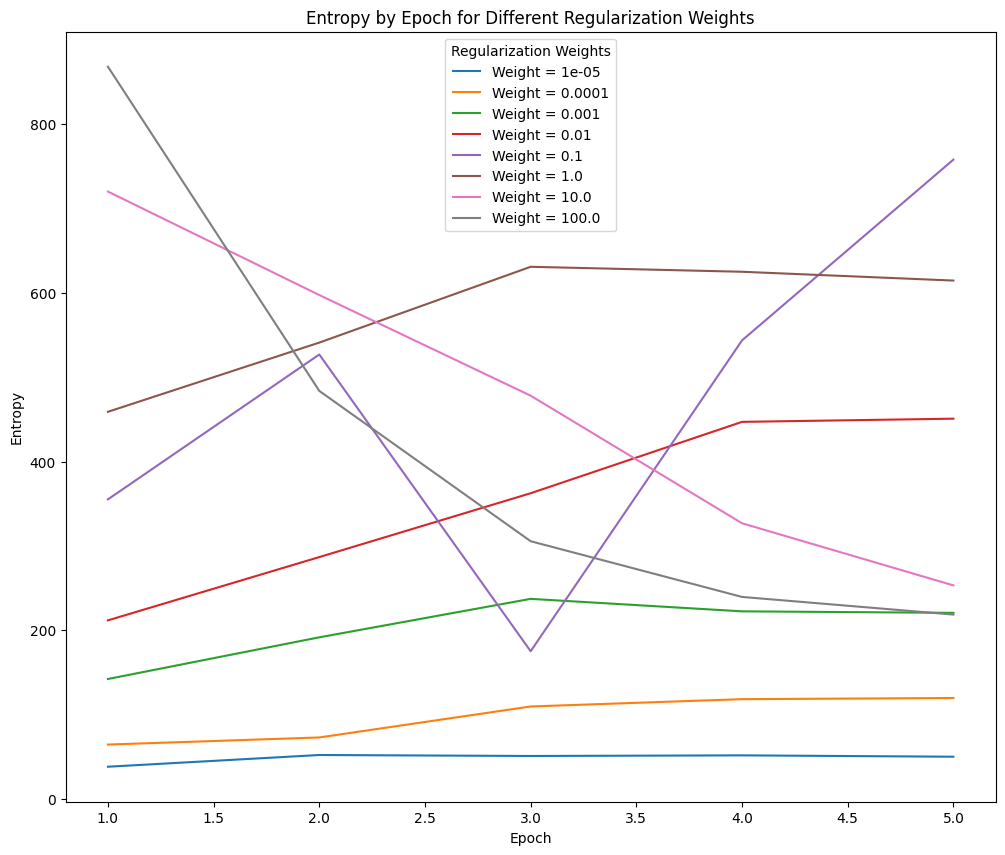

In [26]:
plt.figure(figsize=(12, 10))
for i, entropies in enumerate(average_entropies):
  plt.plot(np.arange(1,6), entropies, label = f'Weight = {rates[i]}')

plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy by Epoch for Different Regularization Weights')
plt.legend(title="Regularization Weights")
plt.show()

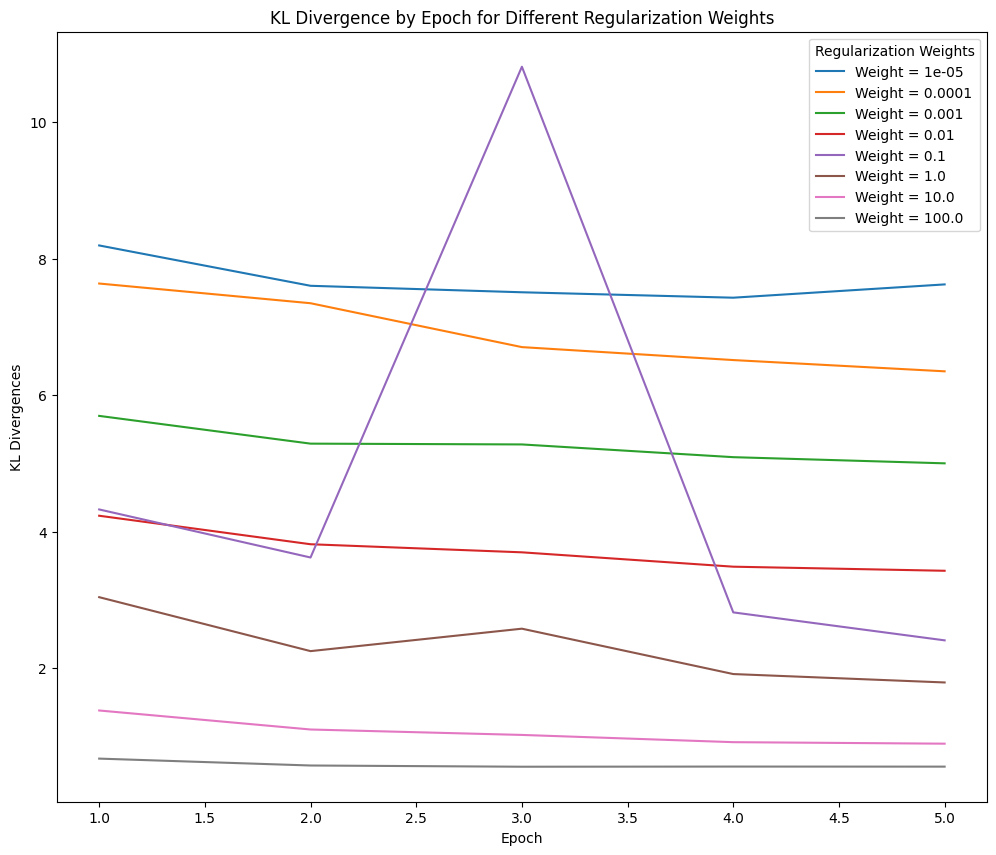

In [27]:
plt.figure(figsize=(12, 10))
for i, kls in enumerate(average_kls):
  plt.plot(np.arange(1,6), kls, label = f'Weight = {rates[i]}')

plt.xlabel('Epoch')
plt.ylabel('KL Divergences')
plt.title('KL Divergence by Epoch for Different Regularization Weights')
plt.legend(title="Regularization Weights")
plt.show()

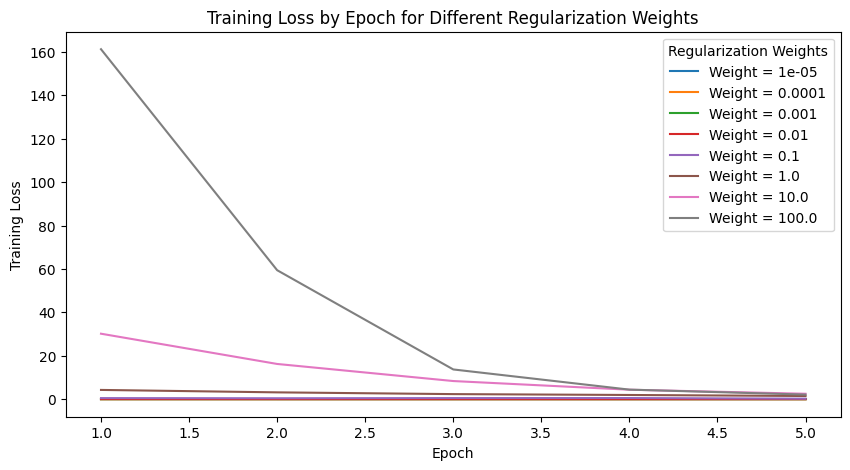

In [28]:
plt.figure(figsize=(10, 5))
for i, entropies in enumerate(training_losses):
  plt.plot(np.arange(1,6), entropies, label = f'Weight = {rates[i]}')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss by Epoch for Different Regularization Weights')
plt.legend(title="Regularization Weights")
plt.show()

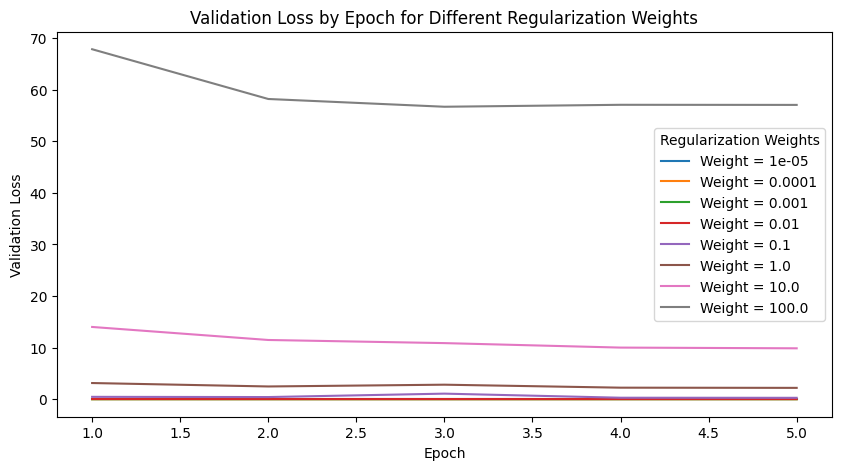

In [29]:
plt.figure(figsize=(10, 5))
for i, entropies in enumerate(validation_losses):
  plt.plot(np.arange(1,6), entropies, label = f'Weight = {rates[i]}')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss by Epoch for Different Regularization Weights')
plt.legend(title="Regularization Weights")
plt.show()

In [45]:
def create_model(total_words, max_sequence_len, custom_loss=None):
    input_len = max_sequence_len - 1
    model = Sequential([
        Embedding(total_words, 10, input_length=input_len),
        LSTM(100),
        Dropout(0.1),
        Dense(total_words, activation='linear')
    ])
    loss = custom_loss
    model.compile(loss=loss, optimizer='adam')
    return model

def original_loss(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)

def custom_loss(y_true, y_pred):
    kl_div = kl_divergence(y_true, y_pred)
    return keras.losses.mean_squared_error(y_true, y_pred) +   100 * kl_divergence(y_true, y_pred)


expected_model = create_model(total_words, max_sequence_len, custom_loss=original_loss)
modified_model = create_model(total_words, max_sequence_len, custom_loss=custom_loss)


In [46]:
modified_model.fit(predictors_train, labels_train, epochs=5, verbose=5, validation_data=(predictors_val, labels_val), callbacks=[custom_metrics_modified])


Epoch 1/5
Epoch 1: mean KL divergence = 0.7006843090057373, mean entropy = 884.2615356445312
train loss = 159.42843627929688
validation Loss = 70.4240493774414
Epoch 2/5
Epoch 2: mean KL divergence = 0.5767573118209839, mean entropy = 495.925048828125
train loss = 55.1374397277832
validation Loss = 58.48831558227539
Epoch 3/5
Epoch 3: mean KL divergence = 0.5649867057800293, mean entropy = 308.5146789550781
train loss = 13.31292724609375
validation Loss = 57.574729919433594
Epoch 4/5
Epoch 4: mean KL divergence = 0.559406042098999, mean entropy = 238.8456268310547
train loss = 4.140931129455566
validation Loss = 57.19380569458008
Epoch 5/5
Epoch 5: mean KL divergence = 0.5588567852973938, mean entropy = 221.03587341308594
train loss = 2.1527676582336426
validation Loss = 57.218589782714844


In [47]:
def generate_text(seed_text, next_words, model, max_sequence_len, k=5):
    index_word = {index: word for word, index in tokenizer.word_index.items()}

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        predictions = model.predict(token_list, verbose=0).flatten()
        indices = np.argpartition(predictions, -k)[-k:]
        predictions = predictions[indices] / np.sum(predictions[indices])
        predicted_index = np.random.choice(indices, p=predictions)

        output_word = index_word.get(predicted_index, '')
        seed_text += " " + output_word

    return seed_text.title()


In [48]:
print (generate_text("united states", 10, modified_model, max_sequence_len))
print (generate_text("president trump", 10, modified_model, max_sequence_len))
print (generate_text("donald trump", 10, modified_model, max_sequence_len))
print (generate_text("india and china", 10, modified_model, max_sequence_len))
print (generate_text("new york", 10, modified_model, max_sequence_len))
print (generate_text("science and technology", 10, modified_model, max_sequence_len))

United States Crash An Left An 23 An Flight 23 Flight An
President Trump 23 An 23 Left An Left Left 23 Flight An
Donald Trump 23 Flight 23 23 An 23 Flight An Left An
India And China 23 An 23 Flight Left An An Flight An 23
New York 23 Left 23 23 Flight Crash Left Crash An Crash
Science And Technology An Flight 23 23 Crash Flight Left Flight An Left
